In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex

from tqdm import tqdm

# Draw the Simplicial Complex

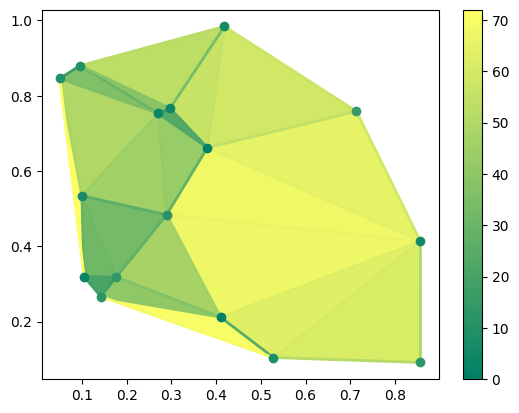

In [3]:
n, dim = 16, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())

# Define and iterate Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_random_transposition(order, neighbours=True):
    #
    if neighbours:
        tr0 = np.random.randint(len(order) - 1)
        tr1 = tr0 + 1
    else:
        tr0, tr1 = np.random.choice(np.arange(len(order)), 2, replace=False)
    new_order = order[:]
    new_order[tr0], new_order[tr1] = new_order[tr1], new_order[tr0]
    if order_is_possible(new_order):
        return tr0, tr1
    else:
        return get_random_transposition(order, neighbours=neighbours)

In [7]:
order = list(np.array(simplices, dtype=object)[np.argsort(filtration_values)])
print('; '.join([f'{i}: {s}' for i, s in enumerate(order)]))

0: [0]; 1: [1]; 2: [2]; 3: [3]; 4: [4]; 5: [5]; 6: [6]; 7: [7]; 8: [8]; 9: [9]; 10: [10]; 11: [11]; 12: [12]; 13: [13]; 14: [14]; 15: [15]; 16: [3, 4]; 17: [9, 10]; 18: [12, 14]; 19: [2, 12]; 20: [2, 14]; 21: [2, 12, 14]; 22: [1, 4]; 23: [1, 3]; 24: [1, 3, 4]; 25: [0, 8]; 26: [7, 11]; 27: [11, 14]; 28: [1, 11]; 29: [2, 7]; 30: [3, 10]; 31: [7, 14]; 32: [2, 7, 14]; 33: [7, 11, 14]; 34: [4, 6]; 35: [3, 9]; 36: [3, 9, 10]; 37: [0, 14]; 38: [4, 10]; 39: [3, 4, 10]; 40: [0, 12]; 41: [0, 12, 14]; 42: [3, 11]; 43: [1, 3, 11]; 44: [3, 7]; 45: [3, 7, 11]; 46: [0, 11]; 47: [0, 11, 14]; 48: [7, 9]; 49: [5, 13]; 50: [3, 7, 9]; 51: [8, 13]; 52: [6, 10]; 53: [4, 6, 10]; 54: [1, 15]; 55: [1, 6]; 56: [1, 4, 6]; 57: [6, 15]; 58: [5, 15]; 59: [1, 6, 15]; 60: [5, 8]; 61: [5, 8, 13]; 62: [0, 5]; 63: [0, 5, 8]; 64: [1, 5]; 65: [1, 5, 15]; 66: [5, 11]; 67: [0, 5, 11]; 68: [1, 5, 11]; 69: [8, 12]; 70: [0, 8, 12]; 71: [2, 9]; 72: [2, 7, 9]


In [8]:
tr0, tr1 = get_random_transposition(order)
tr0, tr1

(68, 69)

In [9]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [10]:
get_transposition_type(stree, order[tr0], order[tr1])

'birth-death'

# Measure the difference Between Depth Posets

In [11]:
tr0, tr1 = get_random_transposition(order, neighbours=True)
s0, s1 = order[tr0], order[tr1]
print(f'Transposition of elements index {tr0} and {tr1}: <{s0}, {s1}>')

order0 = order[:]
order1 = order[:]
order1[tr0], order1[tr1] = order1[tr1], order1[tr0]

if len(order0) <= 32:
    for i, (s0, s1) in enumerate(zip(order0, order1)):
        if i in [tr0, tr1]:
            print(f'<{i}>', s0, s1)
        else:
            print(f' {i} ', s0, s1)

Transposition of elements index 50 and 51: <[3, 7, 9], [8, 13]>


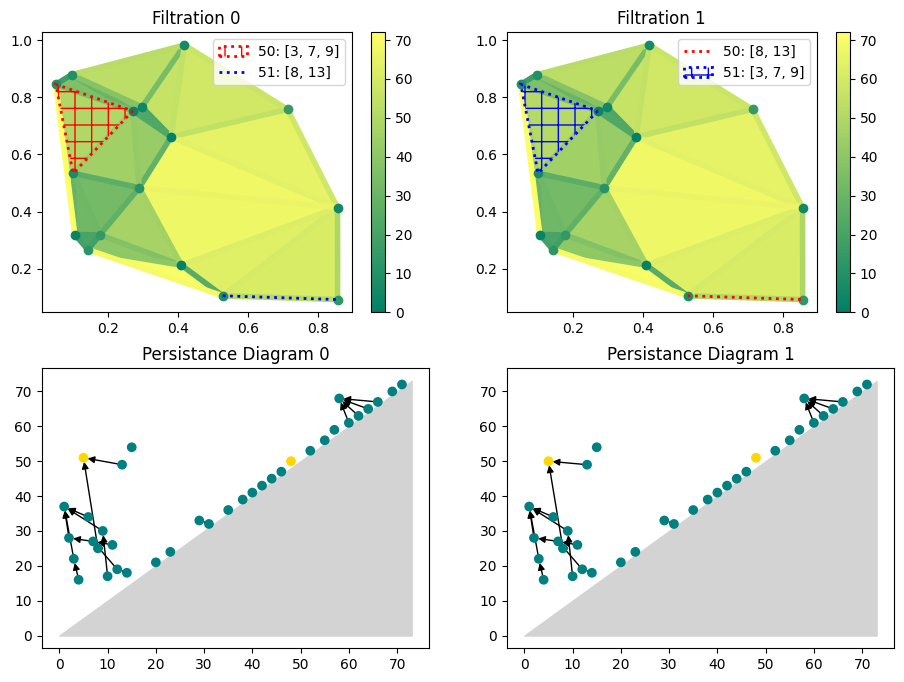

In [12]:
stree0 = stree.copy()
stree1 = stree0.copy()
stree1.assign_filtration(s0, stree0.filtration(s1))
stree1.assign_filtration(s1, stree0.filtration(s0))


for filtration_value, (s0, s1) in enumerate(zip(order0, order1)):
    stree0.insert(s0, filtration=filtration_value)
    stree1.insert(s1, filtration=filtration_value)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(11, 8))

cmap = plt.get_cmap('summer')
for i, (stree, order, dp) in enumerate([(stree0, order0, dp0), (stree1, order1, dp1)]):
    axs[0, i].set_title(f'Filtration {i}')
    sm = plot_filtred_complex2d(stree, points, ax=axs[0, i], cmap=cmap, linewidth=4)
    plt.colorbar(sm, ax=axs[0, i])

    # drowing transposed simplices
    s0, s1 = order[tr0], order[tr1]
    plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', label=f'{tr0}: {s0}', zorder=4)
    plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', label=f'{tr1}: {s1}', zorder=4)
    axs[0, i].legend()

    axs[1, i].set_title(f'Persistance Diagram {i}')
    node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dp.nodes]
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[1, i], 
                     node_color=node_color, node_size=36, 
                     labels=dp.get_labels(), 
                     with_labels=False, hide_ticks=False)
    axs[1, i].fill_between([0, len(order)], [0, len(order)], [0, 0], color='lightgrey')
    axs[1, i].set_xlim(*(len(order)*np.array([-0.05, 1.05])))
    axs[1, i].set_ylim(*(len(order)*np.array([-0.05, 1.05])))


# Construct Default Scores

In [13]:
def unique(input_list):
    """
    Returns the list of unique elements in input_list
    """
    seen = set()
    result = []
    
    for elem in input_list:
        if isinstance(elem, np.ndarray):
            # Convert np.array to a tuple for hashable representation
            identifier = (np.ndarray, elem.shape, tuple(elem.ravel()))
        else:
            # Use the element directly for hashable types
            identifier = elem
        
        # Check for uniqueness
        if identifier not in seen:
            seen.add(identifier)
            result.append(elem)
    
    return result

In [14]:
def get_nodes_intersection(dp0, dp1):
    """
    Returns the array of nodes, which are in both posets.
    """
    nodes = []
    for node in dp0.nodes:
        if node in dp1.nodes:
            nodes.append(node)
    return unique(nodes)

def get_nodes_union(dp0, dp1):
    """
    Returns the array of nodes, which is union of all nodels
    """
    nodes = list(dp0.nodes) + list(dp1.nodes)
    return unique(nodes)

In [15]:
def count_nodes_intersection(dp0, dp1):
    """
    Counts the number of nodes present in the intersection of two depth posets.
    """
    return len(get_nodes_intersection(dp0, dp1))

def count_nodes_union(dp0, dp1):
    """
    Counts the number of nodes present in the union of two depth posets.
    """
    return len(get_nodes_union(dp0, dp1))

def nodes_intersection_over_union(dp0, dp1):
    """
    Computes the ratio of the intersection size to the union size for nodes in two depth posets.
    """
    try:
        return count_nodes_intersection(dp0, dp1)/count_nodes_union(dp0, dp1)
    except ZeroDivisionError:
        return 1

In [16]:
count_nodes_intersection(dp0, dp1), count_nodes_union(dp0, dp1), nodes_intersection_over_union(dp0, dp1)

(36, 38, 0.9473684210526315)

In [17]:
def get_edges_in_reduction_intersection(dp0, dp1):
    """
    Returns the array of edges, which are in both posets transitive reductions. 
    """
    edges = []
    for edge in dp0.get_transitive_reduction().edges:
        if edge in dp1.get_transitive_reduction().edges:
            edges.append(edge)
    return unique(edges)


def get_edges_in_reduction_union(dp0, dp1):
    """
    Returns the union of all edges from both posets transitive reductions
    """
    edges = list(dp0.get_transitive_reduction().edges) + list(dp1.get_transitive_reduction().edges)
    return unique(edges)

In [18]:
def count_edges_in_reduction_intersection(dp0, dp1):
    """
    Counts the number of edges present in the intersection of two depth posets transitive reductions.
    """
    return len(get_edges_in_reduction_intersection(dp0, dp1))

def count_edges_in_reduction_union(dp0, dp1):
    """
    Counts the number of edges present in the union of two depth posets transitive reductions.
    """
    return len(get_edges_in_reduction_union(dp0, dp1))

def edges_in_reduction_intersection_over_union(dp0, dp1):
    """
    Computes the ratio of the intersection size to the union size for edges in two depth posets transitive reductions.
    """
    try:
        return count_edges_in_reduction_intersection(dp0, dp1)/count_edges_in_reduction_union(dp0, dp1)
    except ZeroDivisionError:
        return 1

In [19]:
(count_edges_in_reduction_intersection(dp0, dp1), 
 count_edges_in_reduction_union(dp0, dp1), 
 edges_in_reduction_intersection_over_union(dp0, dp1))

(15, 19, 0.7894736842105263)

# Hypothesis to check

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

In [20]:
arr = np.array([(), (), (2, 3, ), (4, )], dtype=object)

np.unique(arr)

array([(), (2, 3), (4,)], dtype=object)

In [21]:
def get_node_with_simplex(dp, simplex):
    for node in dp.nodes:
        if tuple(np.sort(simplex)) == tuple(np.sort(node.source[0])) or tuple(np.sort(simplex)) == tuple(np.sort(node.source[1])):
            return node

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
$$


## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$


In [22]:
def nodes_intersection_over_union_successors(dp0: DepthPoset, dp1: DepthPoset, s, format_poset=lambda p: p):
    """
    Calculate the nodes_intersection_over_union for 2 succesors subposets of given poset formating this
    """
    try:
        node0 = [node for node in dp0.nodes if tuple(np.sort(s)) == tuple(np.sort(node.source[0])) or 
                                               tuple(np.sort(s)) == tuple(np.sort(node.source[1]))][0]
        node1 = [node for node in dp1.nodes if tuple(np.sort(s)) == tuple(np.sort(node.source[0])) or 
                                               tuple(np.sort(s)) == tuple(np.sort(node.source[1]))][0]
        condition0 = lambda other: dp0.lower(other, node0)
        condition1 = lambda other: dp1.lower(other, node1)
        sdp0 = format_poset(dp0).subposet(node_condition=condition0)
        sdp1 = format_poset(dp1).subposet(node_condition=condition1)
        return nodes_intersection_over_union(sdp0, sdp1)
    except IndexError:
        msg = f'The node with simplex {s} does not exist.'
        raise IndexError(msg)

In [23]:
def nodes_intersection_over_union_l33_first(dp0, dp1, s0, s1, stree0):
    """
    """
    if get_transposition_type(stree0, s0, s1) != 'birth-death':
        return None
    for node in dp0.nodes:
        if tuple(np.sort(node.source[1])) == tuple(np.sort(s0)) or tuple(np.sort(node.source[1])) == tuple(np.sort(s1)):
            sa = node.source[0]
    return nodes_intersection_over_union_successors(dp0, dp1, sa)

In [24]:
def nodes_intersection_over_union_l33_last(dp0, dp1, s0, s1, stree0):
    """
    """
    if get_transposition_type(stree0, s0, s1) != 'birth-death':
        return None
    for node in dp0.nodes:
        if tuple(np.sort(node.source[0])) == tuple(np.sort(s0)) or tuple(np.sort(node.source[0])) == tuple(np.sort(s1)):
            sy = node.source[1]
    return nodes_intersection_over_union_successors(dp0, dp1, sy)

In [25]:
def edges_in_reduction_intersection_over_union_successors(dp0: DepthPoset, dp1: DepthPoset, s, format_poset=lambda p: p):
    """
    Calculate the nodes_intersection_over_union for 2 succesors subposets of given poset formating this
    """
    try:
        node0 = [node for node in dp0.nodes if tuple(np.sort(s)) == tuple(np.sort(node.source[0])) or 
                                               tuple(np.sort(s)) == tuple(np.sort(node.source[1]))][0]
        node1 = [node for node in dp1.nodes if tuple(np.sort(s)) == tuple(np.sort(node.source[0])) or 
                                               tuple(np.sort(s)) == tuple(np.sort(node.source[1]))][0]
        condition0 = lambda other: dp0.lower(other, node0)
        condition1 = lambda other: dp1.lower(other, node1)
        sdp0 = format_poset(dp0).subposet(node_condition=condition0)
        sdp1 = format_poset(dp1).subposet(node_condition=condition1)
        return edges_in_reduction_intersection_over_union(sdp0, sdp1)
    except IndexError:
        msg = f'The node with simplex {s} does not exist.'
        raise IndexError(msg)

In [26]:
def edges_in_reduction_intersection_over_union_l33_first(dp0, dp1, s0, s1, stree0):
    """
    """
    if get_transposition_type(stree0, s0, s1) != 'birth-death':
        return None
    for node in dp0.nodes:
        if tuple(np.sort(node.source[1])) == tuple(np.sort(s0)) or tuple(np.sort(node.source[1])) == tuple(np.sort(s1)):
            sa = node.source[0]
    return edges_in_reduction_intersection_over_union_successors(dp0, dp1, sa)

In [27]:
def edges_in_reduction_intersection_over_union_l33_last(dp0, dp1, s0, s1, stree0):
    """
    """
    if get_transposition_type(stree0, s0, s1) != 'birth-death':
        return None
    for node in dp0.nodes:
        if tuple(np.sort(node.source[0])) == tuple(np.sort(s0)) or tuple(np.sort(node.source[0])) == tuple(np.sort(s1)):
            sy = node.source[1]
    return edges_in_reduction_intersection_over_union_successors(dp0, dp1, sy)

## Hypothesis 1: 
Suppose $a$ and $b$ are 2-simplices consecutive in the ordering by $f$. And there is another Morse function $f^*$: 
$$
f^*(s) = 
\begin{cases}
f(s), \; \text{if} \; s\ne a, b \\
f(b), \; \text{if} \; s = a \\
f(a), \; \text{if} \; s = b
\end{cases}
$$
Let's denote $DP_{f}$ the transitive reduction of the Depth Poset defined by the filtration $f$. And let's deonote $DP_{f}(s)$ the set of nodes in $DP_f(s)$ which are pairs containing cell $s$ and the set of edges with these nodes.

__Hypothesis:__ if the cell $s$ has no faces and cofaces with $a$ and $b$, then $DP_f(s) = DP_{f^*}(s)$.

In [28]:
def is_face_coface_pair(face, coface):
    """
    Returns True if the given pair of simolices are face and coface to each other
    """
    if len(face) + 1 != len(coface):
        return False
    return tuple(np.sort(face)) == tuple(np.sort(np.intersect1d(face, coface)))

In [29]:
is_face_coface_pair([1, 6, 4], [3, 4, 6, 1])

True

In [30]:
def get_faces(simplices, coface):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(simplex, coface):
            res.append(simplex)
    return res

In [31]:
def get_cofaces(simplices, face):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(face, simplex):
            res.append(simplex)
    return res

In [32]:
def get_cofaces_of_faces(simplices, simplex):
    """
    """
    res = []
    for face in get_faces(simplices, simplex):
        res += list(get_cofaces(simplices, face))
    return unique(res)

In [33]:
def get_faces_of_cofaces(simplices, simplex):
    """
    """
    res = []
    for coface in get_cofaces(simplices, simplex):
        res += list(get_faces(simplices, coface))
    return unique(res)

In [34]:
def exclude_transposition_from_nodes(nodes, s0, s1, simplices=None):
    """
    Returns the list of nodes, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = unique([node.source[0] for node in nodes] + [node.source[1] for node in nodes])
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    
    return [node for node in nodes if node_condition(node)]

In [35]:
def nodes_intersection_over_union_excluding_neighbours(dp0, dp1, s0, s1):
    """
    Computes the ratio of the intersection size to the union size for nodes in two depth posets, 
    but filtering nodes, s.t. there is no neighbours for transposed simplices.

    Two simplices are neighbours, if they have one face or coface.

    If the hypothesis is True, the value should always be 1.
    """
    intersection = get_nodes_intersection(dp0, dp1)
    union = get_nodes_union(dp0, dp1)

    simplices = unique([node.source[0] for node in union] + [node.source[1] for node in union])
    
    intersection = unique(exclude_transposition_from_nodes(intersection, s0, s1, simplices=simplices))
    union = unique(exclude_transposition_from_nodes(union, s0, s1))
    return len(intersection)/len(union)

In [36]:
def exclude_transposition_from_edges(edges, s0, s1, simplices=None):
    """
    Returns the list of edges, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = []
        for edge in edges:
            simplices += [node.source[0] for node in edge] + [node.source[1] for node in edge]
        simplices = unique(simplices)
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    edge_condition = lambda edge: node_condition(edge[0]) and node_condition(edge[1])
    
    return [edge for edge in edges if edge_condition(edge)]

In [37]:
def edges_in_reduction_intersection_over_union_excluding_neighbours(dp0, dp1, s0, s1):
    """
    Computes the ratio of the intersection size to the union size for edges in the transitive reductions of two depth posets, 
    but filtering nodes, s.t. there is no neighbours for transposed simplices.

    Two simplices are neighbours, if they have one face or coface.

    If the hypothesis is True, the value should always be 1.
    """
    intersection = get_edges_in_reduction_intersection(dp0, dp1)
    union = get_edges_in_reduction_union(dp0, dp1)

    simplices = []
    for edge in union:
        simplices += [node.source[0] for node in edge] + [node.source[1] for node in edge]
    simplices = unique(simplices)
    
    intersection = unique(exclude_transposition_from_edges(intersection, s0, s1, simplices=simplices))
    union = unique(exclude_transposition_from_edges(union, s0, s1, simplices=simplices))
    if len(intersection) > len(union):
        print(f'Transposition {s0} and {s1}')
        print(f'Intersection ({len(intersection)}): {" ".join([f"({str(e0)})-({str(e1)})" for e0, e1 in intersection])}')
        print(f'Union ({len(union)}): {" ".join([f"({str(e0)})-({str(e1)})" for e0, e1 in union])}')
        print()
    return len(intersection)/len(union)

# Calculate Scores for Transpositions

In [38]:
scores = [nodes_intersection_over_union, 
          edges_in_reduction_intersection_over_union
         ]
scores_t2 = [nodes_intersection_over_union_excluding_neighbours, 
            edges_in_reduction_intersection_over_union_excluding_neighbours, 
           ]
scores_t2s = [nodes_intersection_over_union_l33_first,
              nodes_intersection_over_union_l33_last, 
              edges_in_reduction_intersection_over_union_l33_first, 
              edges_in_reduction_intersection_over_union_l33_last,
              ]

interesting_cols = [score.__name__ for score in scores] + \
                   [score.__name__ for score in scores_t2] + \
                   [score.__name__ for score in scores_t2s]
interesting_cols

['nodes_intersection_over_union',
 'edges_in_reduction_intersection_over_union',
 'nodes_intersection_over_union_excluding_neighbours',
 'edges_in_reduction_intersection_over_union_excluding_neighbours',
 'nodes_intersection_over_union_l33_first',
 'nodes_intersection_over_union_l33_last',
 'edges_in_reduction_intersection_over_union_l33_first',
 'edges_in_reduction_intersection_over_union_l33_last']

In [39]:
order0 = order
stree0 = gh.SimplexTree()
for filtration_value, simplex in enumerate(order0):
    stree0.insert(simplex, filtration=filtration_value)
stree0.compute_persistence()

dp0 = DepthPoset.from_simplex_tree(stree0)

df = []

transpositions_generator = list(iterate_possible_transpositions(order0, neighbours=True))

for tr0, tr1 in tqdm(transpositions_generator, total=len(list(transpositions_generator))):
    s0, s1 = order0[tr0], order0[tr1]
    stree1 = stree0.copy()
    stree1.insert(s0, stree0.filtration(s1))
    stree1.insert(s1, stree0.filtration(s0))

    dp1 = DepthPoset.from_simplex_tree(stree1)

    row = {'Transposition': (tr0, tr1), 
           'Simplices': (s0, s1), 
           'Type': get_transposition_type(stree0, s0, s1)}
    for score in scores:
        row.update({score.__name__: score(dp0, dp1)})
    for score in scores_t2:
        row.update({score.__name__: score(dp0, dp1, s0, s1)})
    for score in scores_t2s:
        row.update({score.__name__: score(dp0, dp1, s0, s1, stree0)})
    df.append(row)

df = pd.DataFrame(df)

print(f'df.shape = {df.shape}')
df.head()

100%|███████████████████████████████████████████| 55/55 [00:06<00:00,  8.36it/s]

df.shape = (55, 11)


,Transposition,Simplices,Type,nodes_intersection_over_union,edges_in_reduction_intersection_over_union,nodes_intersection_over_union_excluding_neighbours,edges_in_reduction_intersection_over_union_excluding_neighbours,nodes_intersection_over_union_l33_first,nodes_intersection_over_union_l33_last,edges_in_reduction_intersection_over_union_l33_first,edges_in_reduction_intersection_over_union_l33_last
0,"(0, 1)","([0], [1])",birth-birth,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,"(1, 2)","([1], [2])",birth-birth,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,"(2, 3)","([2], [3])",birth-birth,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,"(3, 4)","([3], [4])",birth-birth,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,"(4, 5)","([4], [5])",birth-birth,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [40]:
modes = df[interesting_cols].mode().iloc[0]
pd.DataFrame({'mode': modes, 
              'equal mode, %': 100*(df[interesting_cols] == modes).sum()/df[interesting_cols].count()})

,mode,"equal mode, %"
nodes_intersection_over_union,1.0,63.636364
edges_in_reduction_intersection_over_union,1.0,74.545455
nodes_intersection_over_union_excluding_neighbours,1.0,100.000000
edges_in_reduction_intersection_over_union_excluding_neighbours,1.0,100.000000
nodes_intersection_over_union_l33_first,1.0,100.000000
nodes_intersection_over_union_l33_last,1.0,100.000000
edges_in_reduction_intersection_over_union_l33_first,1.0,100.000000
edges_in_reduction_intersection_over_union_l33_last,1.0,100.000000


In [41]:
df_untrivial = df.loc[(df[interesting_cols] != modes).any(axis=1)]

print(f'df_untrivial.shape = {df_untrivial.shape}')
df_untrivial

df_untrivial.shape = (45, 11)


,Transposition,Simplices,Type,nodes_intersection_over_union,edges_in_reduction_intersection_over_union,nodes_intersection_over_union_excluding_neighbours,edges_in_reduction_intersection_over_union_excluding_neighbours,nodes_intersection_over_union_l33_first,nodes_intersection_over_union_l33_last,edges_in_reduction_intersection_over_union_l33_first,edges_in_reduction_intersection_over_union_l33_last
0,"(0, 1)","([0], [1])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1,"(1, 2)","([1], [2])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
2,"(2, 3)","([2], [3])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
3,"(3, 4)","([3], [4])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
4,"(4, 5)","([4], [5])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
5,"(5, 6)","([5], [6])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
6,"(6, 7)","([6], [7])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
7,"(7, 8)","([7], [8])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
8,"(8, 9)","([8], [9])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
9,"(9, 10)","([9], [10])",birth-birth,1.000000,1.000000,1.0,1.0,NaN,NaN,NaN,NaN


In [42]:
pd.DataFrame({
    'Total': df['Type'].value_counts(), 
    'Untrivial': df_untrivial['Type'].value_counts(), 
})

,Total,Untrivial
Type,,
birth-birth,16,16
birth-death,24,14
death-death,15,15
